In [1]:
import numpy as np
import math
from sympy import *
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time

In [2]:
def chi2(T):
    p = T[0]; q = T[1]; r = T[2]; s = T[3]; t = T[4]; u = T[5]
    S = 0
    if p+q != 0:
        S += ((p-q)**2)/(p+q)
    if r+s != 0:
        S += ((r-s)**2)/(r+s)
    if t+u != 0:
        S += ((t-u)**2)/(t+u)
    return S

In [3]:
def DOLS_chi2(x,n,m):
    TG = np.zeros((m,6))
    for i in range(m):
        for j in range(n):
            TG[i][int(x[j][i])] += 1
            
    #Step 1
    MCP = np.zeros((m,6)); MCN = np.zeros((m,6)) #MaxChange
    for i in range(m):
        T = TG[i]
        X = chi2(T); MCP[i] = np.zeros(6); MCN[i] = np.zeros(6)
        if T[0] >= 1:
            Y = chi2([T[0]-1, T[1], T[2]+1, T[3], T[4], T[5]])
            MCP[i][0] = max(MCP[i][0], Y-X); MCN[i][0] = max(MCN[i][0], X-Y)
            Y = chi2([T[0]-1, T[1], T[2], T[3], T[4]+1, T[5]])
            MCP[i][0] = max(MCP[i][0], Y-X); MCN[i][0] = max(MCN[i][0], X-Y)
        if T[1] >= 1:
            Y = chi2([T[0], T[1]-1, T[2], T[3]+1, T[4], T[5]])
            MCP[i][1] = max(MCP[i][1], Y-X); MCN[i][1] = max(MCN[i][1], X-Y)
            Y = chi2([T[0], T[1]-1, T[2], T[3], T[4], T[5]+1])
            MCP[i][1] = max(MCP[i][1], Y-X); MCN[i][1] = max(MCN[i][1], X-Y)
        if T[2] >= 1:
            Y = chi2([T[0]+1, T[1], T[2]-1, T[3], T[4], T[5]])
            MCP[i][2] = max(MCP[i][2], Y-X); MCN[i][2] = max(MCN[i][2], X-Y)
            Y = chi2([T[0], T[1], T[2]-1, T[3], T[4]+1, T[5]])
            MCP[i][2] = max(MCP[i][2], Y-X); MCN[i][2] = max(MCN[i][2], X-Y)
        if T[3] >= 1:
            Y = chi2([T[0], T[1]+1, T[2], T[3]-1, T[4], T[5]])
            MCP[i][3] = max(MCP[i][3], Y-X); MCN[i][3] = max(MCN[i][3], X-Y)
            Y = chi2([T[0], T[1], T[2], T[3]-1, T[4], T[5]+1])
            MCP[i][3] = max(MCP[i][3], Y-X); MCN[i][3] = max(MCN[i][3], X-Y)
        if T[4] >= 1:
            Y = chi2([T[0]+1, T[1], T[2], T[3], T[4]-1, T[5]])
            MCP[i][4] = max(MCP[i][4], Y-X); MCN[i][4] = max(MCN[i][4], X-Y)
            Y = chi2([T[0], T[1], T[2]+1, T[3], T[4]-1, T[5]])
            MCP[i][4] = max(MCP[i][4], Y-X); MCN[i][4] = max(MCN[i][4], X-Y)
        if T[5] >= 1:
            Y = chi2([T[0], T[1]+1, T[2], T[3], T[4], T[5]-1])
            MCP[i][5] = max(MCP[i][5], Y-X); MCN[i][5] = max(MCN[i][5], X-Y)
            Y = chi2([T[0], T[1], T[2], T[3]+1, T[4], T[5]-1])
            MCP[i][5] = max(MCP[i][5], Y-X); MCN[i][5] = max(MCN[i][5], X-Y)
    
    #Step 2
    LSS = np.zeros(int(2**m))
    for j in range(n):
        LSJ = np.zeros((m,int(2**m)))
        LSJ[0][0] = MCP[0][int(x[j][0])]; LSJ[0][1] = MCN[0][int(x[j][0])]
        #print(LSJ[0],LSJ[1])
        for i in range(1,m):
            for k in range(2**i):
                LSJ[i][2*k+0] = LSJ[i-1][k] + MCP[i][int(x[j][i])]
                LSJ[i][2*k+1] = LSJ[i-1][k] + MCN[i][int(x[j][i])]
        #print(LSJ)
        for i in range(int(2**m)):
            LSS[i] = max(LSS[i],LSJ[m-1][i])    
        #print(LSS)
        
    #Step 3
    DOLSP = np.zeros(m) #LS^{i+}
    DOLSN = np.zeros(m) #LS^{i-}
    
    for j in range(m):
        for i in range(int(2**m)):
            if int(i/(2**(m-1-j)))%2 == 0:
                DOLSP[j] = max(DOLSP[j], LSS[i])
            else:
                DOLSN[j] = max(DOLSN[j], LSS[i])
    
    return DOLSP, DOLSN

In [4]:
def DOLS_chi2_original(x,n,m):
    TG = np.zeros((m,6)); T = np.zeros((m,6))
    for i in range(m):
        for j in range(n):
            TG[i][int(x[j][i])] += 1
            T[i][int(x[j][i])] += 1
    
    DOLSP = np.zeros(m); DOLSN = np.zeros(m)
    for j in range(n):
        for i in range(m):
            TG[i][int(x[j][i])] -= 1
        for k in range(int(3**m)):
            for i in range(m):
                TG[i][2*(int(k/(3**i))%3)+(int(x[j][i])%2)] += 1
            for i in range(m):
                C = 0
                for l in range(m):
                    if l != i:
                        C += math.fabs(chi2(T[l]) - chi2(TG[l]))
                DOLSP[i] = max(DOLSP[i], C + chi2(TG[i]) - chi2(T[i]))
                DOLSN[i] = max(DOLSN[i], C + chi2(T[i]) - chi2(TG[i]))
            for i in range(m):
                TG[i][2*(int(k/(3**i))%3)+(int(x[j][i])%2)] -= 1
        for i in range(m):
            TG[i][int(x[j][i])] += 1
    
    return DOLSP, DOLSN

In [5]:
n = 10; m = 4
x = np.zeros((n,m))

for j in range(n):
    for i in range(m):
        x[j][i] = random.randrange(6)

print(DOLS_chi2(x,n,m))
print(DOLS_chi2_original(x,n,m))

(array([6.8       , 7.8       , 7.13333333, 7.13333333]), array([7.8, 7. , 7.8, 7.8]))
(array([6.8       , 7.8       , 7.13333333, 7.13333333]), array([7.8, 7. , 7.8, 7.8]))


[[7.72142410e-04 1.24319458e-01]
 [1.24497414e-03 2.56338453e-01]
 [1.70698166e-03 3.74461651e-01]
 [2.15606689e-03 4.94755983e-01]
 [2.62980461e-03 6.17865658e-01]
 [3.13167572e-03 7.62794447e-01]
 [3.67283821e-03 8.90298223e-01]
 [4.05974388e-03 1.00394821e+00]
 [4.67081070e-03 1.11352630e+00]
 [4.86354828e-03 1.23343091e+00]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


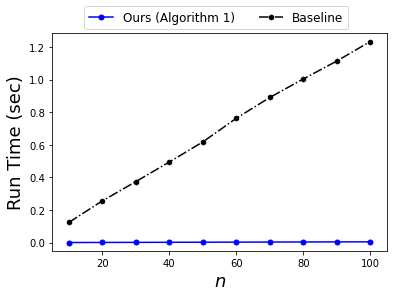

In [6]:
m = 4
n = [10*(i+1) for i in range(10)]

rt = np.zeros((10,2))
for k in range(5):
    for l in range(10):
        x = np.zeros((n[l],m))
        for j in range(n[l]):
            for i in range(m):
                x[j][i] = random.randrange(6)
        s = time.time()
        DOLS_chi2(x,n[l],m)
        e = time.time()
        rt[l][0] += e-s
        s = time.time()
        DOLS_chi2_original(x,n[l],m)
        e = time.time()
        rt[l][1] += e-s
rt /= 5

print(rt)

fig = plt.figure()
plt.ylim(-0.05, max(rt[i][j] for i in range(10) for j in range(2))+0.05)
plt.xlim(5, 105)
plt.plot(n, rt[:,0], marker="o", markersize=5, color = "blue", linestyle = "-", label = "Ours (Algorithm 1)")
plt.plot(n, rt[:,1], marker="h", markersize=5, color = "black", linestyle = "dashdot", label = "Baseline")
plt.xlabel("$n$", fontsize = 18)
plt.ylabel("Run Time (sec)", fontsize = 18)
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=4, fontsize=12)
fig.savefig("RunTime_mFixed_chi2.png")
fig.savefig("figs/RunTime_mFixed_chi2.eps", bbox_inches="tight", pad_inches=0.05)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[1.95169449e-04 1.22575760e-03]
 [4.45365906e-04 1.00107193e-02]
 [7.79914856e-04 5.65945148e-02]
 [1.28517151e-03 2.70596790e-01]
 [2.63891220e-03 1.16129689e+00]]


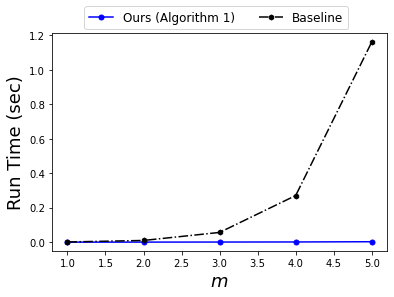

In [7]:
n = 20
m = [1,2,3,4,5]

rt = np.zeros((5,2))
for k in range(5):
    for l in range(5):
        x = np.zeros((n,m[l]))
        for j in range(n):
            for i in range(m[l]):
                x[j][i] = random.randrange(6)
        s = time.time()
        DOLS_chi2(x,n,m[l])
        e = time.time()
        rt[l][0] += e-s
        s = time.time()
        DOLS_chi2_original(x,n,m[l])
        e = time.time()
        rt[l][1] += e-s
rt /= 5

print(rt)

fig = plt.figure()
plt.ylim(-0.05, max(rt[i][j] for i in range(5) for j in range(2))+0.05)
plt.xlim(0.8,5.2)
plt.plot(m, rt[:,0], marker="o", markersize=5, color = "blue", linestyle = "-", label = "Ours (Algorithm 1)")
plt.plot(m, rt[:,1], marker="h", markersize=5, color = "black", linestyle = "dashdot", label = "Baseline")
plt.xlabel("$m$", fontsize = 18)
plt.ylabel("Run Time (sec)", fontsize = 18)
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=4, fontsize=12)
fig.savefig("RunTime_nFixed_chi2.png")
fig.savefig("figs/RunTime_nFixed_chi2.eps", bbox_inches="tight", pad_inches=0.05)